In numerical linear algebra for large datasets, a common problem that arises in the analysis of large datasets is the product of a dense but structured $N \times N$ matrix $\mathbf{A} = \bigotimes_{j=1}^J \mathbf{A}_j$ with a similarly dense vector $\mathbf{y}$. We're assuming that $\mathbf{A}$ can be written as the tensor or Kronecker product of $J$ smaller matrices denoted by $\mathbf{A}_j$, each of which has dimension $N_j$. 

Our strategy in computing this is to rearrange $\mathbf{y}$ into a multdimensional array and, by contracting indices in an efficient way, avoid an $\mathcal{O}(N^2)$ matrix-vector operation. Some of the commonly used identities of product matrices are available on [Wikipedia](https://en.wikipedia.org/wiki/Kronecker_product), and we'll make use of several of them. We let $\mathbf{Y}$ denote an array formed from the vector $\mathbf{y}$ by reshaping into a form with axis dimensions of $N_1,...,N_J$. By the associative property of the tensor product,
\begin{align}
\left(\bigotimes_{j=1}^J \mathbf{A}_j \right) \mathbf{y}&=\mathbf{A}_1\otimes\left(\cdot\cdot\cdot\otimes(\mathbf{A}_J\mathbf{Y})\right)\\
&=u^{(1)}_{k_1,k_2}u^{(2)}_{k_3,k_4}\cdot\cdot\cdot u^{(J)}_{k_{2J-1},k_{2J}}Y_{k_2,k_4,...,k_{2J}}
\end{align}
where we let $u^{(1)}_{k_1k_2}$ refer to the entry of the $k_1$-th row and $k_2$-th column of $\mathbf{A}_1$. The second equation above uses [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation) in representing the tensor product and multidimensional array $\mathbf{Y}$. The $k$ indices look a little funky compared to usual tensor notation; in physics we are used to having actual letters such as $i, j, k$ rather than letters with numbers. However, if we have an arbitrary number of Kronecker factors, there may be many, many indices used, so we avoid using any particular letter and instead replace $i, j, k, l, m,...$ with $k_1, k_2, k_3, k_4, k_5,...$.

The rule for Einstein notation is that when an index appears twice, we sum over it, also described as "contraction" over that index. Contracting the repeated indices, the result of the above procedure is an array $\mathbf{Z}$ of the same dimensions as $\mathbf{Y}$ running over indices $k_1, k_3,...,k_{2J-1}$ which has been transformed by the repeated application of the matrix and tensor product operations and which satisfies the equality 
\begin{equation}
    Vec(\mathbf{Z})=\left(\bigotimes_{j=1}^J \mathbf{A}_j \right) \mathbf{y}.
\end{equation}
Since each of the $J$ tensor contractions involves a sum involving $N_j$ terms, each of which makes use of all $N$ elements in $\mathbf{Y}$, the overall complexity of this algorithm is $\mathcal{O}(N \cdot \sum_{j=1}^J N_j)$, which compares favorably with the naive $\mathcal{O}(N^2)$. 

This entire procedure can be run in a single call to the `einsum` function available in Numpy.
 
Here, I should note that this is essentially the same result characterized by [Saatchi's PhD](http://mlg.eng.cam.ac.uk/pub/pdf/Saa11.pdf) thesis, but this presentation omits the dependence upon permutation indices and transpositions that obscures the essential index operations involved. Alex Williams has an [implementation](https://gist.github.com/ahwillia/f65bc70cb30206d4eadec857b98c4065) of this calculation in PyTorch, but it does the index juggling by hand and is a bit more complex than automatically contracting the right indices. 
In the rest of this notebook, I show how to implement this operation in a few lines of Python.

### Implementing an efficient matrix-vector product

To begin, we'll cook up a set of 5 square, symmetric matrices of increasing size. We'll guarantee they are symmetic and positive semidefinite by squaring them.

In [1]:
import numpy as np
import time

sizes = 3,4,5,6,7
prod_size = np.prod(sizes)

matrices = [np.random.randn(n,n) for n in sizes]
matrices = [X@X.T for X in matrices]



In the end, we want to take the Kronecker / tensor product of these matrices. Since they have increasing dimension, the dimension of their Kronecker product will be `3*4*5*6*7=2520`

In [2]:
[A.shape for A in matrices]

[(3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]

As promised, these matrices are invertible as shown by their determinants. Since each of these determinants is nonzero, an inverse exists.


In [3]:
[np.linalg.det(A) for A in matrices]

[19.055143537578502,
 0.041852313010475074,
 0.008158197604522445,
 43.252474950990084,
 798.5649833818011]

We will also instantiate the vector $\mathbf{y}$, though here we create it in the array form and then vectorize it later.

In [4]:
y = np.random.randn(*sizes)

Here, we perform a brute-force calculation of the matrix-vector product by instantiating the full Kronecker product. We do this by iteratively applying the Kronecker product to each of the matrices.

In [5]:
from functools import reduce
big_matrix = reduce(np.kron, matrices)
matrix_product = big_matrix @ y.ravel()

We'll also do the same using the `einsum` function. The first argument is a string specification for the tensor contraction. Essentially, it is saying that we have 5 two-dimensional arrays (with indices `ij`, `kl`, and so on), and that they are multiplied with a 5-dimensional array to output another 5-dimensional array.

In [6]:
tensors = matrices+[y]
einstein_product = np.einsum('ij,kl,mn,op,qr,ikmoq->jlnpr', *tensors)


Both procedures result in the same values! Note that if you use the elementwise `==` operator overloaded by Numpy, you will get `False` due to minor differences due to the floating point representation.

In [7]:
np.allclose(matrix_product, einstein_product.ravel())

True

The next code cell packages up these functions so we can reuse them later to assess the relative runtimes of each.

In [8]:
from string import ascii_lowercase as letters

def mv_kron(matrices, y):
    '''
    Compute product of vector and Kronecker-structured matrix
    via brute-force enumeration of entire Kronecker matrix.
    '''
    A_kron = reduce(np.kron, matrices)
    return A_kron @ y.ravel()

def mv_einstein(matrices, y):
    '''
    Use Einstein summation convention to iteratively
    contract along secondary axes and implement Kronecker 
    matrix-vector product
    '''
    p = len(matrices)
    
    if p > 13:
        raise ValueError('There aren\'t enough letters in the alphabet for this operation :(')
    
    letter_pairs = [letters[2*i]+letters[2*i+1] for i in range(p)]
    matrix_string = ','.join(letter_pairs)
    vec_in_string, vec_out_string = [''.join(s) for s in zip(*letter_pairs)]
    string_spec = f'{matrix_string},{vec_in_string}->{vec_out_string}'
    
    return np.einsum(string_spec, *matrices, y, optimize='greedy').ravel(), string_spec

### Comparing runtimes

In [18]:
ein_times  = []
kron_times = []
dimensions = []

for scale in [1, 2, 3, 4, 5, 6, 7, 8]:
    sizes = [2*scale, 4*scale, 8*scale]
    matrices = [np.random.randn(n,n) for n in sizes]
    matrices = [X@X.T for X in matrices]
    y = np.random.randn(*sizes)
    
    start_kron = time.perf_counter()
    mv_kron(matrices, y)
    end_kron = time.perf_counter() - start_kron
    
    start_ein = time.perf_counter()
    _, string_spec = mv_einstein(matrices, y)
    end_ein = time.perf_counter() - start_ein
    
    ein_times  += [end_ein]
    kron_times += [end_kron]
    dimensions += [y.size]
    print('Dimension:', str(y.size).ljust(5), f'Einstein time: {end_ein:.3f} s.', f'Naive time {end_kron:.3f}s.')



Dimension: 64    Einstein time: 0.001 s. Naive time 0.001s.
Dimension: 512   Einstein time: 0.000 s. Naive time 0.016s.
Dimension: 1728  Einstein time: 0.000 s. Naive time 0.039s.
Dimension: 4096  Einstein time: 0.000 s. Naive time 0.190s.
Dimension: 8000  Einstein time: 0.001 s. Naive time 0.921s.
Dimension: 13824 Einstein time: 0.001 s. Naive time 2.632s.
Dimension: 21952 Einstein time: 0.018 s. Naive time 7.073s.
Dimension: 32768 Einstein time: 0.063 s. Naive time 95.083s.


As we can see below, there's a big disparity in runtime, although I can't really probe any larger dimension sizes since my laptop has a small amount of memory.

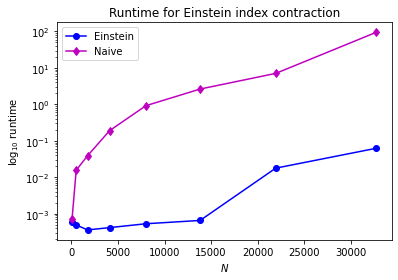

In [24]:
import matplotlib.pyplot as plt

plt.plot(dimensions, ein_times, marker='o', color='b', label='Einstein')
plt.plot(dimensions, kron_times, marker='d', color='m', label='Naive')
plt.yscale('log')
plt.ylabel('$\log_{10}$ runtime'), plt.xlabel('$N$')
plt.legend(), plt.title('Runtime for Einstein index contraction')
plt.savefig('../figures/kmvp_runtime.png', dpi=400);


Finally, it's interesting to note that behind-the-scenes, the Numpy implementation of `einsum` is performing a *path optimization* to determine which indices should be contracted first. We can check it out by calling `einsum_path` and examining the results.

In [21]:
[print(string) for string in np.einsum_path(string_spec, *matrices, y)];

['einsum_path', (2, 3), (1, 2), (0, 1)]
  Complete contraction:  ab,cd,ef,ace->bdf
         Naive scaling:  6
     Optimized scaling:  4
      Naive FLOP count:  4.295e+09
  Optimized FLOP count:  7.340e+06
   Theoretical speedup:  585.143
  Largest intermediate:  3.277e+04 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 ace,ef->acf                           ab,cd,acf->bdf
   4                 acf,cd->adf                              ab,adf->bdf
   4                 adf,ab->bdf                                 bdf->bdf


This printout tells us two things: first, the number of floating point operations is nearly 600X smaller for the optimized summation path. Second, the largest array held in memory is only on the order of $10^4$ elements, so it's much more memory efficient.